In [ ]:
!pip3 install kwant

     |████████████████████████████████| 1.6 MB 4.3 MB/s 
  Created wheel for kwant: filename=kwant-1.4.3-cp37-cp37m-linux_x86_64.whl size=3691102 sha256=1294f5508c0ca5990b1967a15391d02b6b8370d4b9a5e4af77fbbd3496517b04
  Stored in directory: /root/.cache/pip/wheels/d6/2d/93/6f395cd3f0798d7d9e161dce1c8b8c8bbd04d4547763c926de
  Created wheel for tinyarray: filename=tinyarray-1.2.4-cp37-cp37m-linux_x86_64.whl size=227981 sha256=8266a3940b2a949957dc60268a0d6d77b54788107a6a38f580ca2746998bce3e
  Stored in directory: /root/.cache/pip/wheels/85/c6/1c/6939e2931cfbff5df75758a06084bf67171b640ebdf5febd35
Successfully built kwant tinyarray


In [ ]:
import kwant
from matplotlib import pyplot as plt
import tinyarray as ta
import numpy as np
import scipy.sparse.linalg as sla
import scipy

/usr/local/lib/python3.7/dist-packages/kwant/solvers/default.py:18: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  "Performance can be very poor in this case.", RuntimeWarning)


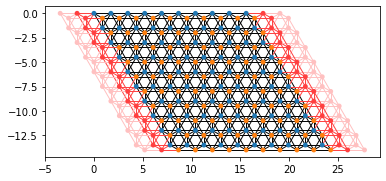

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: RuntimeWarning: The plotted data contains 1.30% of values overflowing upper limit 1.16971 


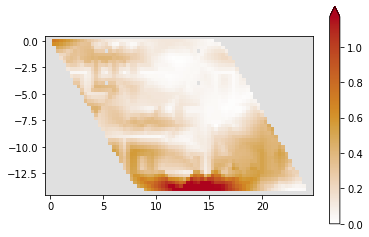

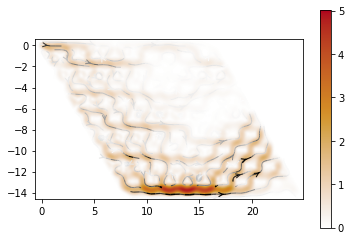

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
/usr/local/lib/python3.7/dist-packag

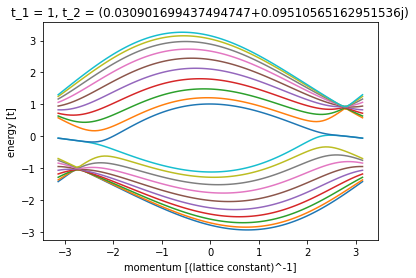

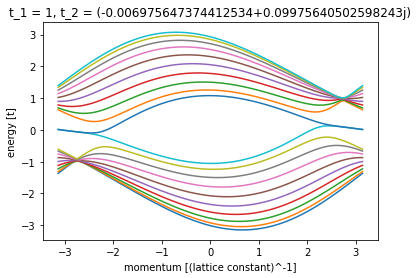

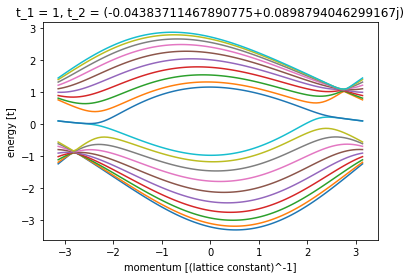

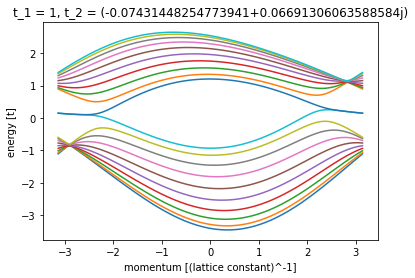

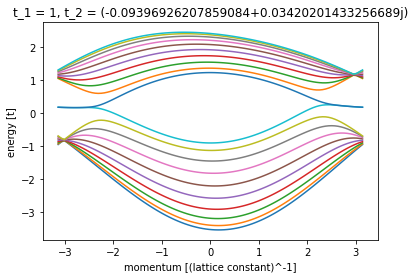

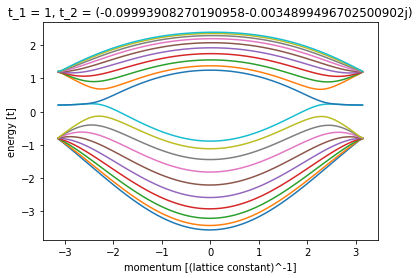

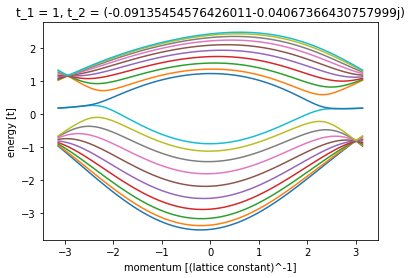

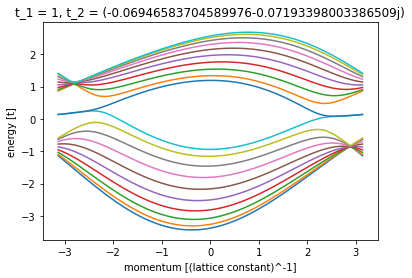

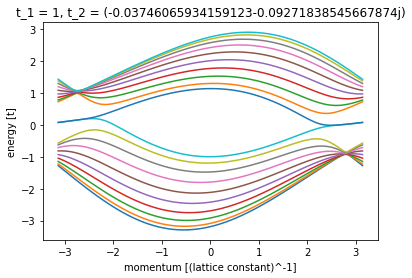

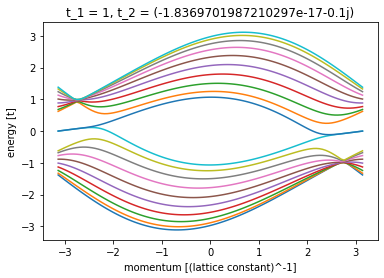

In [ ]:
def make_system(a=1, t_1=1.0, t_2=1.0, L=10, r=3):
    def circle(pos):
        (x, y) = pos
        rsq = x ** 2 + y ** 2
        return rsq < r ** 2
        #return x>=-L//2 and x<<L//2 and y<=L//2 and y>=-L//2

    
    #lat = kwant.lattice.Polyatomic([[3*a/2, np.sqrt(3)*a/2], [3*a/2, -np.sqrt(3)*a/2]], [[0, 0], [a,0]])
    R = np.array([[np.sqrt(3)/2, 1/2],[-1/2, np.sqrt(3)/2]])

    v_1 = [3*a/2, np.sqrt(3)*a/2]
    v_2 = [3*a/2, -np.sqrt(3)*a/2]
    
    r_1 = [0,0]
    r_2 = [a,0]
    
    lat = kwant.lattice.Polyatomic([np.dot(R,v_1), np.dot(R,v_2)], [np.dot(R,r_1), np.dot(R,r_2)],norbs=1)

    lat.a, lat.b = lat.sublattices
    
    syst = kwant.Builder()
    onsite = 0
    # Onsites
    syst[(lat.a(n, m) for n in range(L) for m in range(L))] = onsite
    syst[(lat.b(n, m) for n in range(L) for m in range(L))] = onsite
    # Hopping
    hoppings = (((0, a), lat.a, lat.b), 
                ((a, 0), lat.a, lat.b), 
                ((-a/2, -np.sqrt(3)*a/2), lat.a, lat.b),
                ((-a/2, np.sqrt(3)*a/2), lat.a, lat.b))
    syst[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = t_1
    hoppings2_a = (((0, a), lat.a, lat.a), ((a, 0), lat.a, lat.a), ((a, -a), lat.a, lat.a))
    #hoppings2_a = (((a/2, 3*a/2), lat.a, lat.a))
    hoppings2_b = (((0, a), lat.b, lat.b), ((a, 0), lat.b, lat.b), ((a, -a), lat.b, lat.b))
    syst[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2_a]] = t_2
    syst[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2_b]] = t_2

    
    LEADS = True
    if LEADS:
        # Right lead
        sym_right_lead = kwant.TranslationalSymmetry(np.dot(R,[-3*a/2, -np.sqrt(3)*a/2]))
        #sym_right_lead = kwant.TranslationalSymmetry([2*a,0])
        right_lead = kwant.Builder(sym_right_lead)
        right_lead[(lat.a(n, m) for n in range(L) for m in range(L))] = onsite
        right_lead[(lat.b(n, m) for n in range(L) for m in range(L))] = onsite
        
        # Hopping
        right_lead[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = t_1
        right_lead[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2_a]] = t_2
        right_lead[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2_b]] = t_2
        
        syst.attach_lead(right_lead)
        right_lead_fin = right_lead.finalized()
        
        syst.attach_lead(right_lead.reversed())
    syst_fin = syst.finalized()
    
    if(LEADS):
        return syst_fin, right_lead_fin
    else:
        return syst_fin

def plot_bandstructure(flead, momenta, label=None, title=None):
    bands = kwant.physics.Bands(flead)
    energies = [bands(k) for k in momenta]
    
    plt.figure()
    plt.title(title)
    plt.plot(momenta, energies, label=label)
    plt.xlabel("momentum [(lattice constant)^-1]")
    plt.ylabel("energy [t]")

def plot_conductance(syst, energies):
    # Compute conductance
    data = []
    for energy in energies:
        smatrix = kwant.smatrix(syst, energy)
        data.append(smatrix.transmission(1, 0))

    plt.figure()
    plt.plot(energies, data)
    plt.xlabel("energy [t]")
    plt.ylabel("conductance [e^2/h]")
    plt.show()

def plot_density(sys,ener, it=-1):
    
    wf = kwant.wave_function(sys, energy=ener)
    
    t=np.shape(wf(0))
    nwf=wf(0)[0]*0
    
    
    for i in range(t[0]//2+1):
        test=wf(0)[i]
        nwf+=test

    psi=abs(nwf)**2
    
    if it==-1:
        title="density"
    elif it>-1:
        title= "density"
        
    title2=title+".pdf"
    
    kwant.plotter.map(sys,psi,method='linear',vmin=0)

    J_0 = kwant.operator.Current(sys)
    c = J_0(nwf)

    kwant.plotter.current(sys, c)


    plt.close()




In [ ]:

sys, right_lead = make_system(t_1 = 1, t_2 = 0.5*np.exp(1j))
kwant.plot(sys)
kwant.plot(sys, file='haldane.pdf')

#plot_conductance(sys, np.linspace(0,2,1000))
plot_density(sys, 1)

for phi in np.linspace(2*np.pi/5, 3*np.pi/2, 10):
    t_2 = 0.1 * np.exp(1j*phi)
    sys, right_lead = make_system(t_1 = 1, t_2 = t_2)
    plot_bandstructure(right_lead, np.linspace(-np.pi, np.pi, 100), t_2, title=f"t_1 = 1, t_2 = {t_2}")
    plt.savefig(f't_1 = 1 t_2 = {round(t_2,4)}.pdf')
plt.show()


R = np.array([[1/np.sqrt(2), 1/np.sqrt(2)],[-1/np.sqrt(2), 1/np.sqrt(2)]])
print(np.dot(R,[1,0]))

[ 0.70710678 -0.70710678]


In [ ]:
def plot_probability(ham):
    phi_tab = np.linspace(0, 2*np.pi, 10)
    energies = []
    for phi in phi_tab:
        sys = make_system(t_1 = 1, t_2 = np.exp(1j*phi))
        ham = sys.hamiltonian_submatrix(sparse=True)
        e_val, e_vec = scipy.sparse.linalg.eigsh(ham, k=197, return_eigenvectors=True)
        e_val = np.sort(e_val)
        energies.append(e_val)
        
    plt.figure()
    plt.plot(phi_tab, energies)
    plt.xlabel("t2")
    plt.ylabel("energy [t]")
    plt.show()
    

plot_probability(ham)
    

NameError: ignored